In [1]:
import numpy as np
import tensorflow as tf
import warnings
import matplotlib.pyplot as plt
import random
warnings.filterwarnings("ignore")
import os
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2023-02-05 16:32:30.056591: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-05 16:32:30.279848: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-02-05 16:32:30.874096: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /cm/shared/apps/cudnn-8.4/8.4/lib64:/cm/local/apps/cuda/libs/current/lib64:/cm/shared/apps/cuda11.2/toolkit/11.2.0/targets/x86_64-linux/lib:/cm/local/apps/gcc/7.2.0/lib:/cm/local/apps/gcc/7.2.0/lib64:/hom

Num GPUs Available:  1


## Loading the dataset

In [2]:
# # preprocessing function 
# import cv2
# def reduce_channel(img):
#     return img[:,:,0]

In [3]:
from keras.preprocessing.image import ImageDataGenerator

seed = 909 

image_datagen = ImageDataGenerator(rescale = 1/255) # custom fuction for each image you can use resnet one too.
mask_datagen = ImageDataGenerator(rescale = 1/255.,
                 preprocessing_function = lambda x: np.where(x>0, 1, 0).astype(x.dtype))  # to make mask as feedable formate (256,256,1)

image_generator =image_datagen.flow_from_directory("Skin_Lesion_Dataset/train_imgs/",
                                                    class_mode=None, color_mode = "rgb", batch_size = 32, target_size = (192, 256), seed=seed)

mask_generator = mask_datagen.flow_from_directory("Skin_Lesion_Dataset/train_masks/",
                                                   class_mode=None, color_mode = "grayscale", batch_size = 32, target_size = (192, 256), seed=seed)

train_generator = (pair for pair in zip(image_generator, mask_generator))

image_generator =image_datagen.flow_from_directory("Skin_Lesion_Dataset/validation_imgs/",
                                                    class_mode=None, color_mode = "rgb", batch_size = 32, target_size = (192, 256), seed=seed)

mask_generator = mask_datagen.flow_from_directory("Skin_Lesion_Dataset/validation_masks/",
                                                   class_mode=None, color_mode = "grayscale", batch_size = 32, target_size = (192, 256), seed=seed)

val_generator = (pair for pair in zip(image_generator, mask_generator))

image_generator =image_datagen.flow_from_directory("Skin_Lesion_Dataset/test_imgs/",
                                                    class_mode=None, color_mode = "rgb", batch_size = 32, target_size = (192, 256), seed=seed)

mask_generator = mask_datagen.flow_from_directory("Skin_Lesion_Dataset/test_masks/",
                                                   class_mode=None, color_mode = "grayscale", batch_size = 32, target_size = (192, 256), seed=seed)

test_generator = (pair for pair in zip(image_generator, mask_generator))

Found 2000 images belonging to 1 classes.
Found 2000 images belonging to 1 classes.
Found 150 images belonging to 1 classes.
Found 150 images belonging to 1 classes.
Found 600 images belonging to 1 classes.
Found 600 images belonging to 1 classes.


## Displaying images 

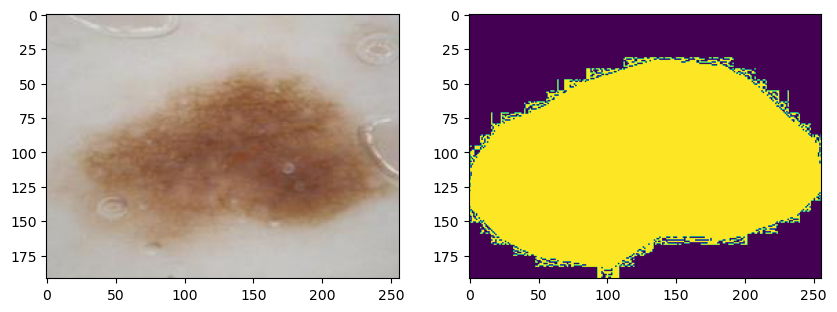

In [4]:
# Training images

img, msk = train_generator.__next__()

img_num = random.randint(0,img.shape[0]-1)
train_img=img[img_num]
train_mask=msk[img_num]


plt.figure(figsize=(10,10))
plt.subplot(121)
plt.imshow(train_img)
plt.subplot(122)
plt.imshow(train_mask)

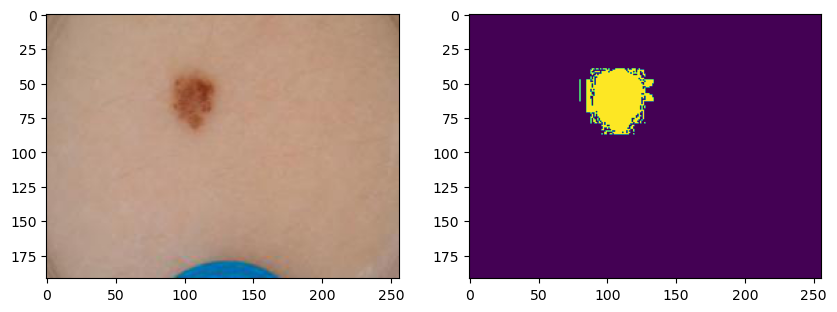

In [5]:
# Validation images

img, msk = val_generator.__next__()

img_num = random.randint(0,img.shape[0]-1)
val_img=img[img_num]
val_mask=msk[img_num]


plt.figure(figsize=(10,10))
plt.subplot(121)
plt.imshow(val_img)
plt.subplot(122)
plt.imshow(val_mask)

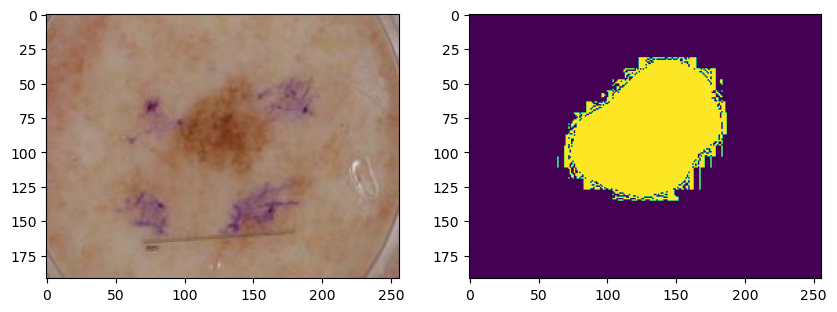

In [6]:
# Test images

img, msk = test_generator.__next__()

img_num = random.randint(0,img.shape[0]-1)
test_img=img[img_num]
test_mask=msk[img_num]


plt.figure(figsize=(10,10))
plt.subplot(121)
plt.imshow(test_img)
plt.subplot(122)
plt.imshow(test_mask)

## Size verification

In [1]:
print(train_img.shape)
print(train_mask.shape)
print(val_img.shape)
print(val_mask.shape)
print(test_img.shape)
print(test_mask.shape)

NameError: name 'train_img' is not defined

## Metrics of evaluation

In [8]:
from keras import backend as K

In [9]:
def iou(y_true, y_pred, smooth = 100):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    sum_ = K.sum(K.square(y_true), axis = -1) + K.sum(K.square(y_pred), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac

In [10]:
def dice_coef(y_true, y_pred, smooth = 100):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
# def dice_coef(y_true, y_pred):
#     y_true_f = tf.reshape(tf.dtypes.cast(y_true, tf.float32), [-1])
#     y_pred_f = tf.reshape(tf.dtypes.cast(y_pred, tf.float32), [-1])
#     intersection = tf.reduce_sum(y_true_f * y_pred_f)
#     return (2. * intersection + 1.) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + 1.)

In [11]:
def precision(y_true, y_pred):
    '''Calculates the precision, a metric for multi-label classification of
    how many selected items are relevant.
    '''
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

In [12]:
def recall(y_true, y_pred):
    '''Calculates the recall, a metric for multi-label classification of
    how many relevant items are selected.
    '''
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

In [13]:
def accuracy(y_true, y_pred):
    '''Calculates the mean accuracy rate across all predictions for binary
    classification problems.
    '''
    return K.mean(K.equal(y_true, K.round(y_pred)))

## Image preprocessing

In [14]:
# If required, define the preprocessing function in flow_from_directory 

## Model creation

In [15]:
from keras.models import Model, Sequential
from keras.layers import Activation, Dense, BatchNormalization, Dropout, Conv2D, Conv2DTranspose, MaxPooling2D, UpSampling2D, Input, Reshape
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam, SGD

In [16]:
def segnet(epochs_num,savename):

    # Encoding layer
    img_input = Input(shape= (192, 256, 3))
    x = Conv2D(64, (3, 3), padding='same', name='conv1',strides= (1,1))(img_input)
    x = BatchNormalization(name='bn1')(x)
    x = Activation('relu')(x)
    x = Conv2D(64, (3, 3), padding='same', name='conv2')(x)
    x = BatchNormalization(name='bn2')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D()(x)
    
    x = Conv2D(128, (3, 3), padding='same', name='conv3')(x)
    x = BatchNormalization(name='bn3')(x)
    x = Activation('relu')(x)
    x = Conv2D(128, (3, 3), padding='same', name='conv4')(x)
    x = BatchNormalization(name='bn4')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D()(x)

    x = Conv2D(256, (3, 3), padding='same', name='conv5')(x)
    x = BatchNormalization(name='bn5')(x)
    x = Activation('relu')(x)
    x = Conv2D(256, (3, 3), padding='same', name='conv6')(x)
    x = BatchNormalization(name='bn6')(x)
    x = Activation('relu')(x)
    x = Conv2D(256, (3, 3), padding='same', name='conv7')(x)
    x = BatchNormalization(name='bn7')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D()(x)

    x = Conv2D(512, (3, 3), padding='same', name='conv8')(x)
    x = BatchNormalization(name='bn8')(x)
    x = Activation('relu')(x)
    x = Conv2D(512, (3, 3), padding='same', name='conv9')(x)
    x = BatchNormalization(name='bn9')(x)
    x = Activation('relu')(x)
    x = Conv2D(512, (3, 3), padding='same', name='conv10')(x)
    x = BatchNormalization(name='bn10')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D()(x)
    
    x = Conv2D(512, (3, 3), padding='same', name='conv11')(x)
    x = BatchNormalization(name='bn11')(x)
    x = Activation('relu')(x)
    x = Conv2D(512, (3, 3), padding='same', name='conv12')(x)
    x = BatchNormalization(name='bn12')(x)
    x = Activation('relu')(x)
    x = Conv2D(512, (3, 3), padding='same', name='conv13')(x)
    x = BatchNormalization(name='bn13')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D()(x)

    x = Dense(1024, activation = 'relu', name='fc1')(x)
    x = Dense(1024, activation = 'relu', name='fc2')(x)
    # Decoding Layer 
    x = UpSampling2D()(x)
    x = Conv2DTranspose(512, (3, 3), padding='same', name='deconv1')(x)
    x = BatchNormalization(name='bn14')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(512, (3, 3), padding='same', name='deconv2')(x)
    x = BatchNormalization(name='bn15')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(512, (3, 3), padding='same', name='deconv3')(x)
    x = BatchNormalization(name='bn16')(x)
    x = Activation('relu')(x)
    
    x = UpSampling2D()(x)
    x = Conv2DTranspose(512, (3, 3), padding='same', name='deconv4')(x)
    x = BatchNormalization(name='bn17')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(512, (3, 3), padding='same', name='deconv5')(x)
    x = BatchNormalization(name='bn18')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(256, (3, 3), padding='same', name='deconv6')(x)
    x = BatchNormalization(name='bn19')(x)
    x = Activation('relu')(x)

    x = UpSampling2D()(x)
    x = Conv2DTranspose(256, (3, 3), padding='same', name='deconv7')(x)
    x = BatchNormalization(name='bn20')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(256, (3, 3), padding='same', name='deconv8')(x)
    x = BatchNormalization(name='bn21')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(128, (3, 3), padding='same', name='deconv9')(x)
    x = BatchNormalization(name='bn22')(x)
    x = Activation('relu')(x)

    x = UpSampling2D()(x)
    x = Conv2DTranspose(128, (3, 3), padding='same', name='deconv10')(x)
    x = BatchNormalization(name='bn23')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(64, (3, 3), padding='same', name='deconv11')(x)
    x = BatchNormalization(name='bn24')(x)
    x = Activation('relu')(x)
    
    x = UpSampling2D()(x)
    x = Conv2DTranspose(64, (3, 3), padding='same', name='deconv12')(x)
    x = BatchNormalization(name='bn25')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(1, (3, 3), padding='same', name='deconv13')(x)
    x = BatchNormalization(name='bn26')(x)
    x = Activation('sigmoid')(x)
    pred = x
    
    model = Model(inputs=img_input, outputs=pred)
    
    model.compile(optimizer= SGD(lr=0.001, momentum=0.9, decay=0.0005, nesterov=False), loss= ["binary_crossentropy"]
                  , metrics=[iou, dice_coef, precision, recall, accuracy])
    model.summary()
    
    train_spe = 2000//32
    val_spe = 150//32
    
    hist = model.fit(train_generator, epochs= epochs_num, steps_per_epoch = train_spe, batch_size= 32, validation_data= val_generator, validation_steps = val_spe, verbose=1)
        
    model.save(savename)
    return model,hist

In [17]:
model, hist = segnet(5, 'segnet_5_epoch.h5')

2023-02-05 16:32:33.924974: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-05 16:32:34.642937: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13814 MB memory:  -> device: 0, name: Tesla V100-PCIE-16GB, pci bus id: 0000:3b:00.0, compute capability: 7.0


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 192, 256, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 192, 256, 64)      1792      
                                                                 
 bn1 (BatchNormalization)    (None, 192, 256, 64)      256       
                                                                 
 activation (Activation)     (None, 192, 256, 64)      0         
                                                                 
 conv2 (Conv2D)              (None, 192, 256, 64)      36928     
                                                                 
 bn2 (BatchNormalization)    (None, 192, 256, 64)      256       
                                                                 
 activation_1 (Activation)   (None, 192, 256, 64)      0     

 2D)                                                             
                                                                 
 deconv4 (Conv2DTranspose)   (None, 24, 32, 512)       2359808   
                                                                 
 bn17 (BatchNormalization)   (None, 24, 32, 512)       2048      
                                                                 
 activation_16 (Activation)  (None, 24, 32, 512)       0         
                                                                 
 deconv5 (Conv2DTranspose)   (None, 24, 32, 512)       2359808   
                                                                 
 bn18 (BatchNormalization)   (None, 24, 32, 512)       2048      
                                                                 
 activation_17 (Activation)  (None, 24, 32, 512)       0         
                                                                 
 deconv6 (Conv2DTranspose)   (None, 24, 32, 256)       1179904   
          

2023-02-05 16:32:39.594626: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100


62/62 [==============================] - 30s 366ms/step - loss: 0.7014 - iou: 0.9978 - dice_coef: 0.0019 - precision: 0.0000e+00 - recall: 0.0000e+00 - accuracy: 0.5945 - val_loss: 0.6275 - val_iou: 0.9978 - val_dice_coef: 0.0017 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_accuracy: 0.8029
Epoch 2/5
62/62 [==============================] - 19s 306ms/step - loss: 0.5583 - iou: 0.9983 - dice_coef: 0.0019 - precision: 0.0000e+00 - recall: 0.0000e+00 - accuracy: 0.7570 - val_loss: 0.5126 - val_iou: 0.9984 - val_dice_coef: 0.0017 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_accuracy: 0.8084
Epoch 3/5
62/62 [==============================] - 19s 306ms/step - loss: 0.4628 - iou: 0.9987 - dice_coef: 0.0019 - precision: 0.0000e+00 - recall: 0.0000e+00 - accuracy: 0.7688 - val_loss: 0.4100 - val_iou: 0.9989 - val_dice_coef: 0.0018 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_accuracy: 0.8018
Epoch 4/5
62/62 [==============================] - 19s 305ms/s